In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, json
import torch
from tqdm import tqdm
from natsort import natsorted

In [3]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader

In [4]:
device = 'cuda'
BATCH_SIZE = 2

## 1. Read Echo-Net Mini Data 

{'LV': [[34, 52], [33, 53], [32, 53], [31, 53], [30, 53], [29, 54], [28, 54], [27, 54], [26, 55], [25, 55], [24, 56], [23, 57], [22, 57], [21, 58], [20, 59], [19, 60], [18, 61], [17, 62], [16, 63], [16, 64], [16, 65], [16, 66], [16, 67], [16, 68], [16, 69], [16, 70], [16, 71], [16, 72], [16, 73], [17, 74], [17, 75], [17, 76], [18, 77], [18, 78], [19, 79], [20, 80], [21, 81], [22, 81], [23, 82], [24, 83], [25, 84], [26, 85], [27, 86], [28, 87], [29, 87], [30, 88], [31, 88], [32, 88], [33, 89], [34, 89], [35, 90], [36, 90], [37, 91], [38, 92], [39, 93], [40, 93], [41, 94], [42, 95], [43, 95], [44, 96], [45, 96], [46, 96], [47, 97], [48, 97], [49, 97], [50, 98], [51, 98], [52, 99], [53, 99], [54, 99], [55, 99], [56, 99], [57, 99], [58, 99], [59, 100], [60, 100], [61, 100], [62, 100], [63, 99], [64, 99], [65, 99], [66, 99], [67, 99], [68, 99], [69, 99], [70, 99], [71, 99], [72, 98], [73, 98], [74, 98], [75, 98], [76, 98], [77, 98], [78, 98], [79, 98], [80, 97], [81, 97], [82, 97], [83, 96]

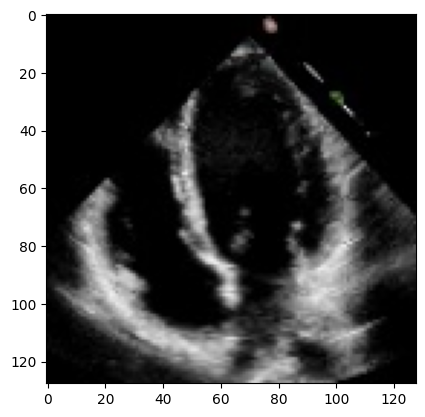

In [5]:
path = 'data/raw/Mini-EchoNet-Dynamic'

img = cv2.imread(os.path.join(path, 'Images', 'frame_1.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(os.path.join(path, 'MasksJsonContours', 'mascara1.json')) as f:
    lbl = json.load(f)
    print(lbl)

print(lbl.keys())
plt.imshow(img)

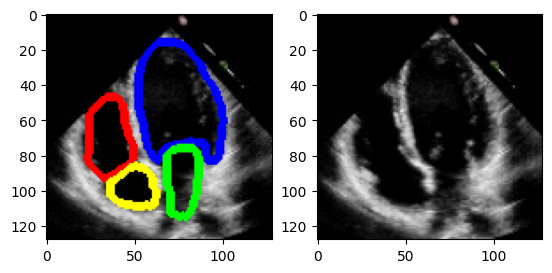

In [6]:
new_img = img.copy()

for key, vals in lbl.items():
    if key == "LV":
        color = (0, 0, 255)
    elif key == "LA":
        color = (0, 255, 0)
    elif key == "RV":
        color = (255, 0, 0)
    else:
        color = (255, 255, 0)
    for val in vals:
        x, y = val[1], val[0]
        cv2.circle(new_img, (x, y), 2, color, -1)

plt.subplot(121)
plt.imshow(new_img);
plt.subplot(122)
plt.imshow(img);

In [7]:
np.array(vals).shape

(74, 2)

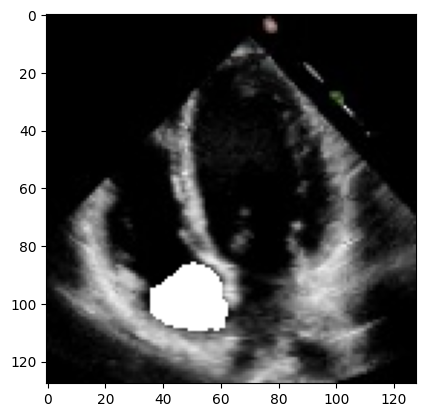

In [8]:
# Fill mask
# points = np.array([[[x1, y1]], ..., [[xn, yn]]])
# # then you can pass these points into the OpenCV function cv2.fillPoly() or cv2.drawContours() to fill in the region.
points = np.array([[[xi, yi]] for yi, xi in vals]).astype(np.int32)
polynomialgon = img.copy()
cv2.fillPoly(polynomialgon, [points], color=[255,255,255])
plt.imshow(polynomialgon)

In [9]:
def get_data(img_paths: list, msk_paths, img_shape=(512, 512), mask_class='LA'):
    """ img_shape - Output image size. Without channels. """

    color = (255, 255, 255)

    n_photo = len(img_paths)      # Batch size
    images = []
    masks = []
    
    for im_path, m_path in tqdm(zip(img_paths, msk_paths), total=n_photo):
        # Open mhd
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #
        mask = np.zeros(image.shape[:2])
        with open(m_path) as f:
            lbl = json.load(f)
        for key, vals in lbl.items():
            if key == mask_class:
                points = np.array([[[xi, yi]] for yi, xi in vals]).astype(np.int32)
                mask = cv2.fillPoly(mask, [points], color=[255,255,255])
                 
        # Resize
        if img_shape:
            # 
            image = cv2.resize(image, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            image = np.clip(image, 0, None)
            image = image / image.max()   # (843, 512, 3)

            mask = cv2.resize(mask, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            mask = np.clip(mask, 0, None)
            mask = mask / mask.max()   # (843, 512, 3)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        # If we want visualize
        # image = np.transpose(image, (1, 2, 0)) 
        image = np.transpose(image, (2, 0, 1)) 
        mask = np.transpose(mask, (2, 0, 1)) 
        # image = np.expand_dims(image, axis=0)  # (1, 3, 512, 512)

        images.append(image)
        masks.append(mask)
        # break
    return np.array(images).astype(np.float32), np.array(masks).astype(np.float32)

In [10]:
# All paths
main_ds_path = 'data/raw/Mini-EchoNet-Dynamic'
im_main_path = os.path.join(main_ds_path, 'Images')
msk_main_path = os.path.join(main_ds_path, 'MasksJsonContours')
img_paths = [os.path.join(im_main_path, im_name) for im_name in natsorted(os.listdir(im_main_path))]
msk_paths = [os.path.join(msk_main_path, im_name) for im_name in natsorted(os.listdir(msk_main_path))]
msk_paths[:5]

['data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara1.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara2.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara3.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara4.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara5.json']

100%|██████████| 100/100 [00:00<00:00, 292.40it/s]


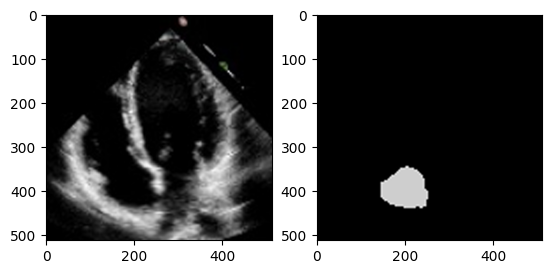

In [11]:
images, masks = get_data(img_paths, msk_paths, img_shape=(512, 512), mask_class='RA')

plt.subplot(121)
plt.imshow(np.transpose(images[0], (1, 2, 0)));
plt.subplot(122)
plt.imshow(np.transpose(masks[0], (1, 2, 0)), 'gray');

In [12]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
    # img = np.einsum('ijk->jki', img)
    # img = (127.5*(img+1)).astype(np.uint8)
    try:
        img = img.cpu().detach().numpy()
        return np.transpose(img, (1, 2, 0))
    except:
        print("Already numpy.array")
        return np.transpose(img, (1, 2, 0))

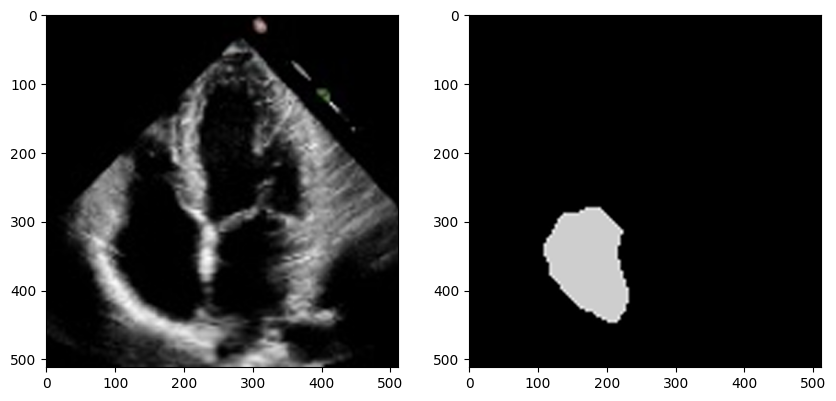

In [13]:
dataset = TensorDataset(torch.from_numpy(images), torch.from_numpy(masks))
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

im, m = dataset[25]
fig = plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

## 2. Load Trained Model

- Transfer weights into new model (Transfer Learning)
- Freeze Decoder
- Train model in new data
- Use Augumentation

In [14]:
model_name = 'u2net-LA'
model_saved_dir = 'results/U2Net'

model_path = F"{model_saved_dir}/{model_name}_best.pt"  # _best

model = U2Net().to(device)


In [15]:
rv_state_dict = torch.load(model_path)
rv_state_dict

OrderedDict([('enc.0.conv.conv.weight',
              tensor([[[[-0.1057,  0.0542,  0.0082],
                        [-0.0393,  0.0197, -0.0564],
                        [-0.0718,  0.0027,  0.0490]],
              
                       [[-0.1188, -0.0525, -0.0185],
                        [ 0.0714,  0.0322, -0.0182],
                        [ 0.0816,  0.0696,  0.0446]],
              
                       [[-0.1153, -0.0120,  0.0730],
                        [-0.0718, -0.0347,  0.0090],
                        [-0.0604, -0.1061, -0.0687]]],
              
              
                      [[[ 0.0560,  0.0760, -0.0186],
                        [-0.0950, -0.1244, -0.0256],
                        [-0.0973, -0.1059, -0.0657]],
              
                       [[ 0.0537,  0.0150,  0.0547],
                        [-0.0885,  0.0153,  0.0351],
                        [-0.1168, -0.0394,  0.0262]],
              
                       [[ 0.0719,  0.0701, -0.0782],
                

In [16]:
ra_state_dict = model.state_dict()
ra_state_dict

OrderedDict([('enc.0.conv.conv.weight',
              tensor([[[[ 0.0799,  0.0256, -0.0717],
                        [-0.0239, -0.0542,  0.0857],
                        [-0.0357,  0.0014,  0.0724]],
              
                       [[ 0.0490,  0.0132, -0.0807],
                        [ 0.0646,  0.0899, -0.0892],
                        [ 0.0198,  0.0829,  0.0997]],
              
                       [[ 0.0362, -0.0942,  0.0557],
                        [-0.0984,  0.0975,  0.0222],
                        [-0.0231, -0.0342,  0.0348]]],
              
              
                      [[[-0.0001, -0.0794, -0.0873],
                        [ 0.0380,  0.0352, -0.0638],
                        [ 0.0821, -0.0929,  0.0847]],
              
                       [[ 0.0601, -0.0482, -0.0162],
                        [-0.0606, -0.0541,  0.0433],
                        [ 0.0983,  0.0772,  0.0158]],
              
                       [[ 0.0119,  0.0014,  0.0580],
                

In [17]:
ra_state_dict['enc.0.conv.conv.weight'].shape

torch.Size([64, 3, 3, 3])

In [18]:
ra_state_dict.keys(), rv_state_dict.keys()

(odict_keys(['enc.0.conv.conv.weight', 'enc.0.conv.conv.bias', 'enc.0.conv.bn.weight', 'enc.0.conv.bn.bias', 'enc.0.conv.bn.running_mean', 'enc.0.conv.bn.running_var', 'enc.0.conv.bn.num_batches_tracked', 'enc.0.enc.0.conv.weight', 'enc.0.enc.0.conv.bias', 'enc.0.enc.0.bn.weight', 'enc.0.enc.0.bn.bias', 'enc.0.enc.0.bn.running_mean', 'enc.0.enc.0.bn.running_var', 'enc.0.enc.0.bn.num_batches_tracked', 'enc.0.enc.1.conv.weight', 'enc.0.enc.1.conv.bias', 'enc.0.enc.1.bn.weight', 'enc.0.enc.1.bn.bias', 'enc.0.enc.1.bn.running_mean', 'enc.0.enc.1.bn.running_var', 'enc.0.enc.1.bn.num_batches_tracked', 'enc.0.enc.2.conv.weight', 'enc.0.enc.2.conv.bias', 'enc.0.enc.2.bn.weight', 'enc.0.enc.2.bn.bias', 'enc.0.enc.2.bn.running_mean', 'enc.0.enc.2.bn.running_var', 'enc.0.enc.2.bn.num_batches_tracked', 'enc.0.enc.3.conv.weight', 'enc.0.enc.3.conv.bias', 'enc.0.enc.3.bn.weight', 'enc.0.enc.3.bn.bias', 'enc.0.enc.3.bn.running_mean', 'enc.0.enc.3.bn.running_var', 'enc.0.enc.3.bn.num_batches_tracked',

In [19]:
len(ra_state_dict), len(rv_state_dict)

(798, 798)

In [20]:
enc_names = []
for key in ra_state_dict.keys():
    if key.split('.')[0] == 'enc':
        enc_names.append(key)

len(enc_names)

420

In [21]:
for enc_name in enc_names:
    rv_state_dict[enc_name] = ra_state_dict[enc_name]

In [22]:
rv_state_dict['dec.0.dec.2.bn.weight'], ra_state_dict['dec.0.dec.2.bn.weight']

(tensor([0.8992, 0.9010, 0.9203, 0.8716, 0.8078, 0.9213, 0.8768, 0.8972, 0.8084,
         0.8574, 0.9534, 0.9133, 0.9173, 0.8833, 0.8785, 0.9087, 0.8820, 0.8462,
         0.9021, 0.8578, 0.8480, 0.8928, 0.8538, 0.8524, 0.8639, 0.9565, 0.9597,
         0.9053, 0.7956, 0.9008, 0.8952, 0.8186, 0.8334, 0.8478, 0.9420, 0.8808,
         0.8375, 0.8847, 1.0057, 0.9175, 0.8403, 0.9519, 0.9104, 0.8439, 0.8772,
         0.8832, 0.8560, 0.9173, 0.8166, 0.8539, 0.9060, 0.8828, 0.8638, 0.9141,
         0.8962, 0.8389, 0.8864, 0.8699, 1.0151, 0.8023, 0.9104, 0.8684, 0.8349,
         0.8645, 0.9045, 0.9217, 0.8160, 0.9544, 0.9188, 0.8900, 0.8896, 0.9108,
         0.8589, 0.9360, 0.9059, 0.9003, 1.0433, 0.8636, 0.9405, 0.8467, 0.8742,
         0.8363, 0.8947, 0.8860, 0.8921, 0.8731, 0.8767, 0.8776, 0.8759, 0.9090,
         0.8835, 0.8770, 0.8713, 0.8103, 0.9455, 0.8775, 0.8375, 0.9065, 0.9273,
         0.8941, 0.9142, 0.8428, 0.8833, 0.8399, 0.8485, 1.0067, 0.9615, 0.8724,
         0.8901, 0.8728, 0.8

#### Freese weights

In [23]:
for i in range(len(enc_names)):
    for param in model.parameters():
        param.requires_grad = False

In [24]:
for param in model.parameters():
    print(param.shape)
    # param.requires_grad = False

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([32])
torc

In [25]:
# Then, unfreeze parameters in (15):
# for i in range(420):
#     for param in model.features[i].parameters():
#         param.requires_grad = True

In [ ]:
# def load_weights(self):
#     pretrained_dict = torch.load('model.torch')
#     model_dict = self.state_dict()

#     # 1. filter out unnecessary keys
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

#     # 2. overwrite entries in the existing state dict
#     model_dict.update(pretrained_dict)

#     # 3. load the new state dict
#     self.load_state_dict(model_dict)

#     # 4. create final layer and initialize it
#     self.linear = nn.Linear(self.output_size, self.n_classes)
#     torch.nn.init.xavier_uniform_(self.linear.weight)
#     self.linear.bias.data.fill_(0.01)
#     self.cuda()  # put model on GPU once again

## Try fit model with new weights

In [26]:
train_loader

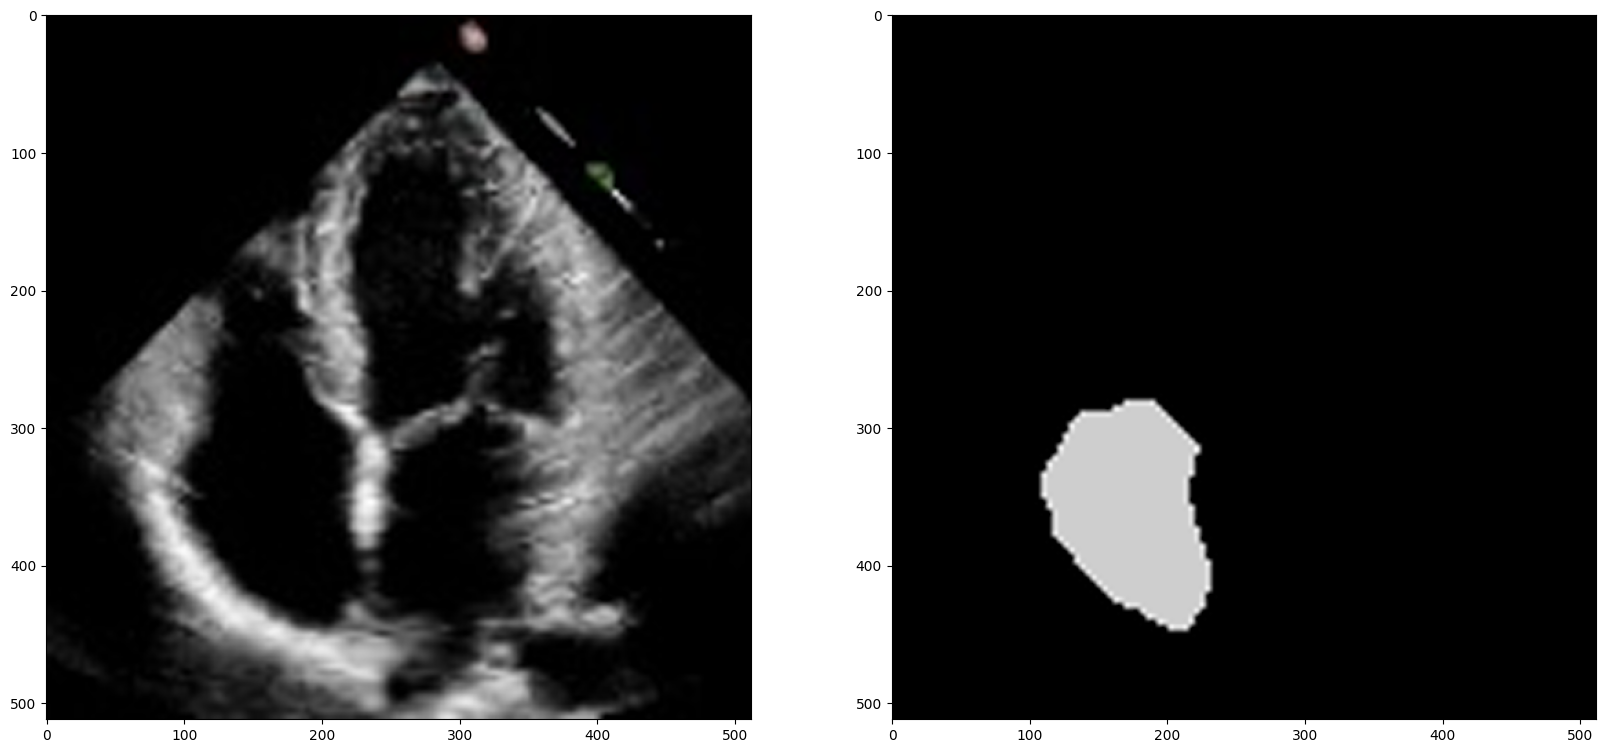

In [27]:
from src.scripts.DataLoaders import ImgForPlot


im, m = dataset[25]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [28]:
im.max(), m.max(), im.shape, m.shape, im.min(), m.min()

(tensor(1.),
 tensor(1.),
 torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 tensor(0.),
 tensor(0.))

In [29]:
from src.scripts.models.U2Net import U2Net
import pickle
import torch.nn as nn
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

In [30]:
# 
lr = 0.0012

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)
model_name = 'u2net-LV'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}_best.pt"
best_model_path = model_path

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

model = U2Net().to(device)
# Continue lerning
# model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

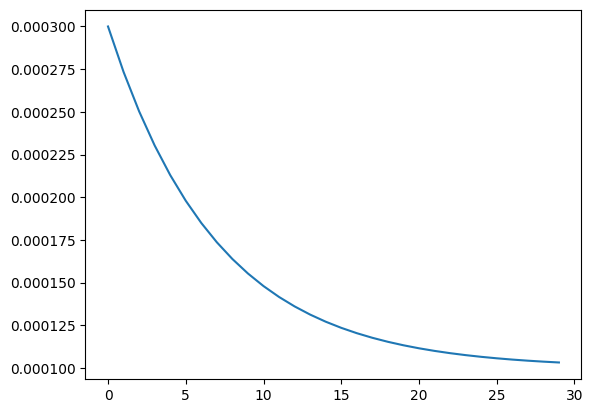

In [31]:
LR_START = 0.0003
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0001
epochs = 5

def ws_lr(epoch, lr):
    return (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW

xx = np.arange(30)

plt.plot(xx, [ws_lr(x, 0.01) for x in xx])

In [32]:
def update_lr(epoch):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [33]:
BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

In [34]:
from time import time

In [35]:
n_print = 10
# start_epoch = 0


# if start_epoch == 0:
#   losses = {'train': [], 'valid': []}
#   best_loss = float("inf")
# else:
#   best_loss = min(losses['valid'])


# for ep in range(start_epoch, epochs):
#     update_lr(ep)
#     step, loss_sum = 0, 0.
#     timestamp = time()
#     for batch_idx, (input, target) in enumerate(train_loader, 0):
#         input = input.to(device)
#         target = target.to(device)
#         step += 1
        
#         # Train Model
#         model.train()
#         optimizer.zero_grad()
        
#         out = model(input)
#         # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
#         each_loss = [ DBCE(o, target) for o in out ]  
#         # each_loss = [ BCE(o, target) for o in out ]  
#         loss = sum(each_loss)
        
#         loss.backward()
#         optimizer.step()

#         # Append Loss
#         losses['train'].append(loss.item())
#         loss_sum += loss.item()

#         if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
#             print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
#             step, loss_sum = 0, 0.
#             timestamp = time()
      
#     # # Evaluate Model
#     # model.eval()
#     # step, loss_sum = 0, 0.
#     # timestamp = time()
#     # with torch.no_grad():
#     #     for input, target in tqdm(valid_dataloader):
#     #         out = model(input.to(device))[-1]
#     #         if out.ndim == 3:
#     #             out = out.unsqueeze(1)
            
#     #         loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
#     #         step += input.size(0)
      
#     #     val_loss = loss_sum / step
#     #     losses['valid'].append(val_loss)
#     #     if val_loss < best_loss:
#     #         best_loss = val_loss
#     #         torch.save(model.state_dict(), best_model_path)

#     # print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

#     # torch.save(model.state_dict(), model_path)
#     # with open(loss_path, 'wb') as f:
#     #     pickle.dump(losses, f)
    
#     print("Saved model completely!")

In [36]:
# Then, unfreeze parameters in (15):
for i in range(420):
    for param in model.parameters():
        param.requires_grad = True

In [37]:
start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs+start_epoch):
    update_lr(ep)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        each_loss = [ DBCE(o, target) for o in out ]  
        # each_loss = [ BCE(o, target) for o in out ]  
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()

Learning Rate: 0.000300
[ 1/ 5][  10/  50] Train: 8.2297 (3s)
[ 1/ 5][  20/  50] Train: 2.8732 (2s)
[ 1/ 5][  30/  50] Train: 2.0322 (2s)
[ 1/ 5][  40/  50] Train: 1.7329 (2s)
[ 1/ 5][  50/  50] Train: 1.6491 (2s)
Learning Rate: 0.000273
[ 2/ 5][  10/  50] Train: 1.5300 (2s)
[ 2/ 5][  20/  50] Train: 1.5543 (2s)
[ 2/ 5][  30/  50] Train: 1.4972 (2s)
[ 2/ 5][  40/  50] Train: 1.5035 (2s)
[ 2/ 5][  50/  50] Train: 1.5241 (2s)
Learning Rate: 0.000250
[ 3/ 5][  10/  50] Train: 1.4975 (2s)
[ 3/ 5][  20/  50] Train: 1.5064 (2s)


KeyboardInterrupt: 

In [38]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [39]:
pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

(512, 512, 1)

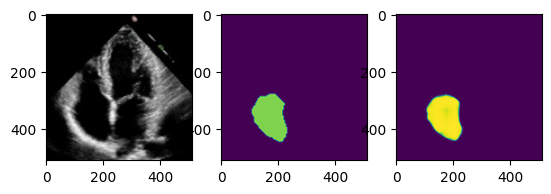

In [40]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
plt.subplot(132)
plt.imshow(ImgForPlot(m));
plt.subplot(133)
plt.imshow(pred)

(944, 1392, 3)


[mjpeg @ 0x628600c72800] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x628600b2f740] unable to decode APP fields: Invalid data found when processing input


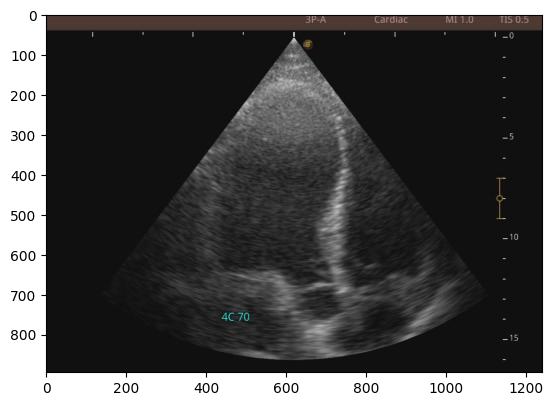

In [41]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame[50:, 150:, :]);

torch.Size([1, 3, 512, 512])
(512, 512, 1)


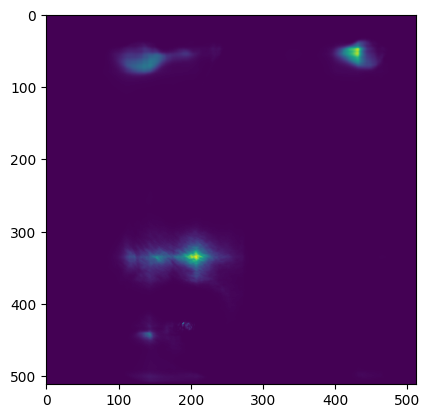

In [42]:
new_img = prepare_input(frame[50:, 150:, :])
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
print(pred.shape)

plt.imshow(pred)